In [271]:
#import libraries and prepare enviroument
%matplotlib inline
get_ipython().run_line_magic('pylab', 'inline')
get_ipython().run_line_magic('load_ext', 'autoreload')
import numpy as np
import urllib.request, json 
import pandas as pd
pd.set_option('display.max_columns', None)

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [186]:
#for normalizing data (to be used)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [187]:
#donwload JSON data from stock prices API
dataurl = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=VALE&outputsize=full&apikey=CL2294CNHOV8RYM8"
with urllib.request.urlopen(dataurl) as url:
    data = json.loads(url.read().decode())

In [188]:
#make the JSON into usable dictionary
data_table = []
temp = {}

for timeseries in data["Time Series (Daily)"]:
    temp["date"] = timeseries
    for level2 in data["Time Series (Daily)"][timeseries]:
        if(level2 == '1. open'):
            temp['open'] = float(data["Time Series (Daily)"][timeseries][level2])
        if(level2 == '2. high'):
            temp['high'] = float(data["Time Series (Daily)"][timeseries][level2])
        if(level2 == '3. low'):
            temp['low'] = float(data["Time Series (Daily)"][timeseries][level2])
        if(level2 == '4. close'):
            temp['close'] = float(data["Time Series (Daily)"][timeseries][level2])
        if(level2 == '5. volume'):
            temp['volume'] = float(data["Time Series (Daily)"][timeseries][level2])
    data_table.append(temp)
    temp = {}
    
#data_array = np.array(data_table)

In [189]:
#load dictionary into a pandas data frame and sort by date
df = pd.DataFrame(data_table)
df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
df.index = df['date']
df = df.sort_index()

In [229]:
#create frames of N samples to input into NN

N = 3

#load 10 rows one after the other
data_table_2 = []
temp = {}
row_num = 0

for row in range(0,len(df.index) - N):   
    for n in range(0,N):    
        if(n == 0):
            temp['date'] = df.iloc[row,:]['date']
            
        temp['open' + str(n)] = df.iloc[row+n,:]['open']
        temp['close' + str(n)] = df.iloc[row+n,:]['close']
        temp['low' + str(n)] = df.iloc[row+n,:]['low']
        temp['high' + str(n)] = df.iloc[row+n,:]['high']
        temp['volume' + str(n)] = df.iloc[row+n,:]['volume']
        
        if(n == N-1):
            #need to calculate if next day open higher or lower than previous day close
            if(df.iloc[row+n+1,:]['open'] > df.iloc[row+n,:]['close']): #means next day opened higher, so 1
                temp['output'] = 1
            else:
                temp['output'] = 0                
        
    data_table_2.append(temp)
    temp = {}


In [252]:
#load new dict with the N windows into a data frame
df2 = pd.DataFrame(data_table_2)
df2['date'] = pd.to_datetime(df2.date,format='%Y-%m-%d')
df2.index = df2['date']
df2 = df2.sort_index()
df2.drop('date', axis=1, inplace=True)

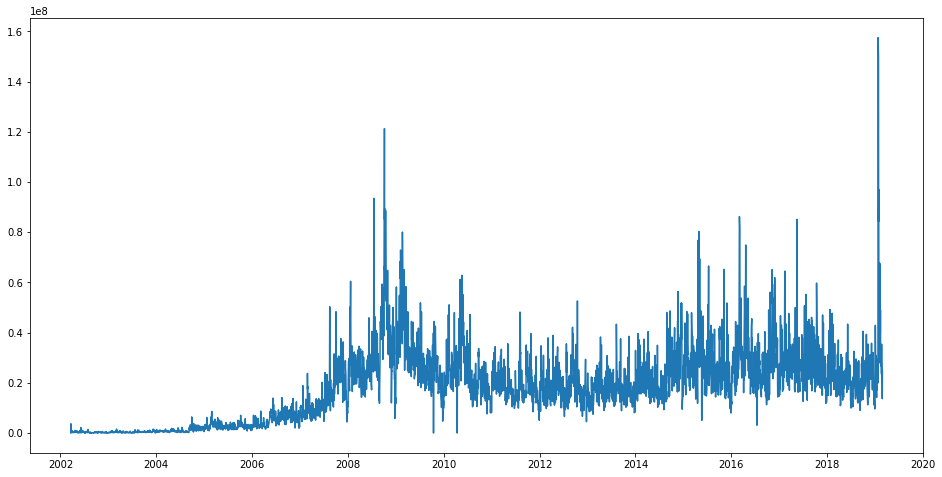

In [82]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [270]:
#creating train and test sets
dataset = df2.values

train = dataset[0:3000,:]
train_y = dataset[0:3000,12]
valid = dataset[3000:,:]

In [258]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [259]:
scaled_data

array([[0.4092556 , 0.39525692, 0.39525692, ..., 0.        , 0.02341297,
        0.00393052],
       [0.39525692, 0.39525692, 0.40662055, ..., 0.02341359, 0.00393052,
        0.00243578],
       [0.39525692, 0.40662055, 0.41337286, ..., 0.00393116, 0.00243578,
        0.00736957],
       ...,
       [0.1627141 , 0.17045455, 0.171278  , ..., 0.22451769, 0.12860348,
        0.15124091],
       [0.17045455, 0.171278  , 0.17078393, ..., 0.12860403, 0.15124091,
        0.0868054 ],
       [0.171278  , 0.17078393, 0.17028986, ..., 0.15124145, 0.0868054 ,
        0.15640964]])

In [261]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

array([0., 1., 0., ..., 0., 0., 0.])